# 载入数据集

In [1]:
import cv2
import h5py
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats, integrate
from sklearn.utils import shuffle

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
n = 25000
n_class = 1
width = 224 # 299

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n), dtype=np.uint8)

epochs = int(n/2)
for i in tqdm(range(epochs)):
    X[i] = cv2.resize(cv2.imread('./train/cat.%s.jpg' % i), (width, width))
    y[i] = 0
    X[epochs + i] = cv2.resize(cv2.imread('./train/dog.%s.jpg' % i), (width, width))
    y[epochs + i] = 1

100%|██████████| 12500/12500 [00:39<00:00, 317.33it/s]


# 数据集可视化

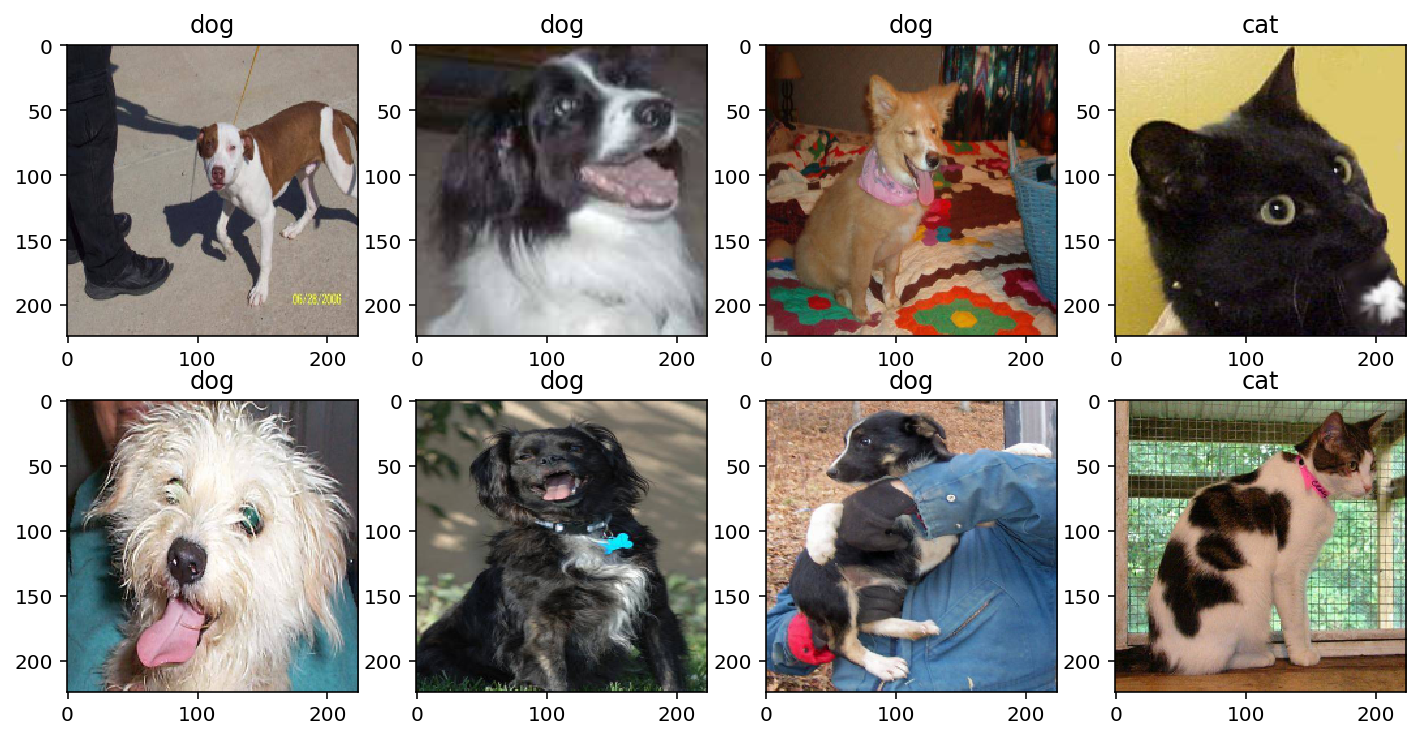

In [3]:
plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    if y[random_index] == 0:
        plt.title('cat')
    else:
        plt.title('dog')

In [30]:
train_size = []

for i in tqdm(range(n/2)):
    img = cv2.imread('./train/cat.%s.jpg' % i)
    train_size.append(img.shape)
    img = cv2.imread('./train/dog.%s.jpg' % i)
    train_size.append(img.shape)
    
df = pd.DataFrame(train_size, columns=["x", "y", "z"])

100%|██████████| 12500/12500 [00:34<00:00, 358.43it/s]


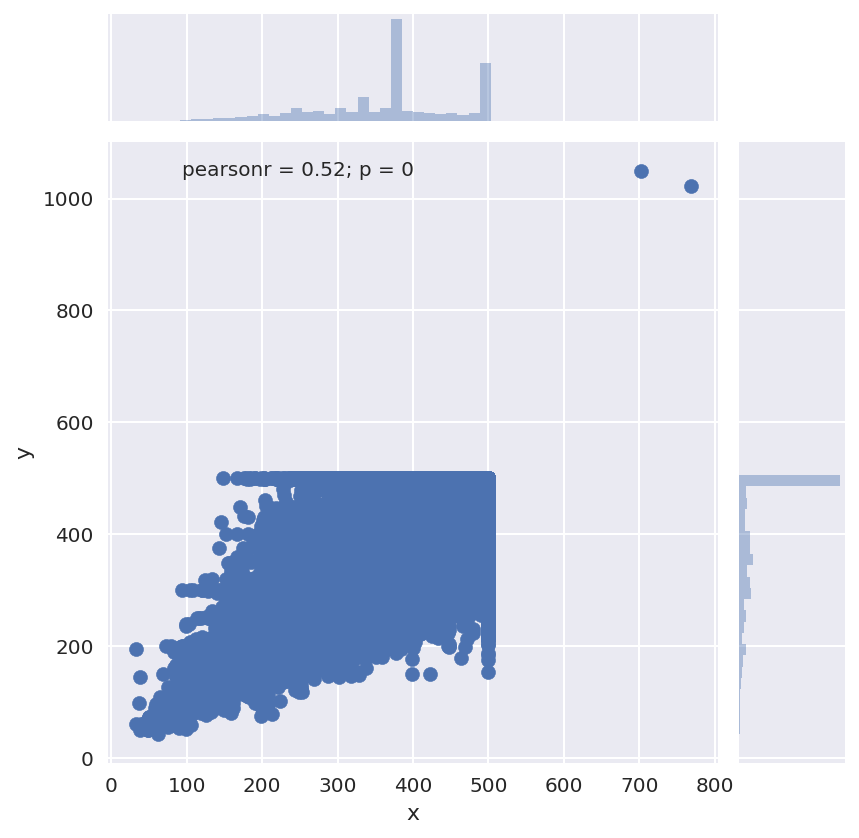

In [31]:
sns.set(color_codes=True)
sns.jointplot(x="x", y="y", data=df);
plt.figure(figsize=(12, 6))

In [32]:
test_size = []

for i in tqdm(range(12500)):
    img = cv2.imread('./test/%s.jpg' % (i+1))
    test_size.append(img.shape)
    
df_test = pd.DataFrame(test_size, columns=["x", "y", "z"])

100%|██████████| 12500/12500 [00:27<00:00, 446.78it/s]


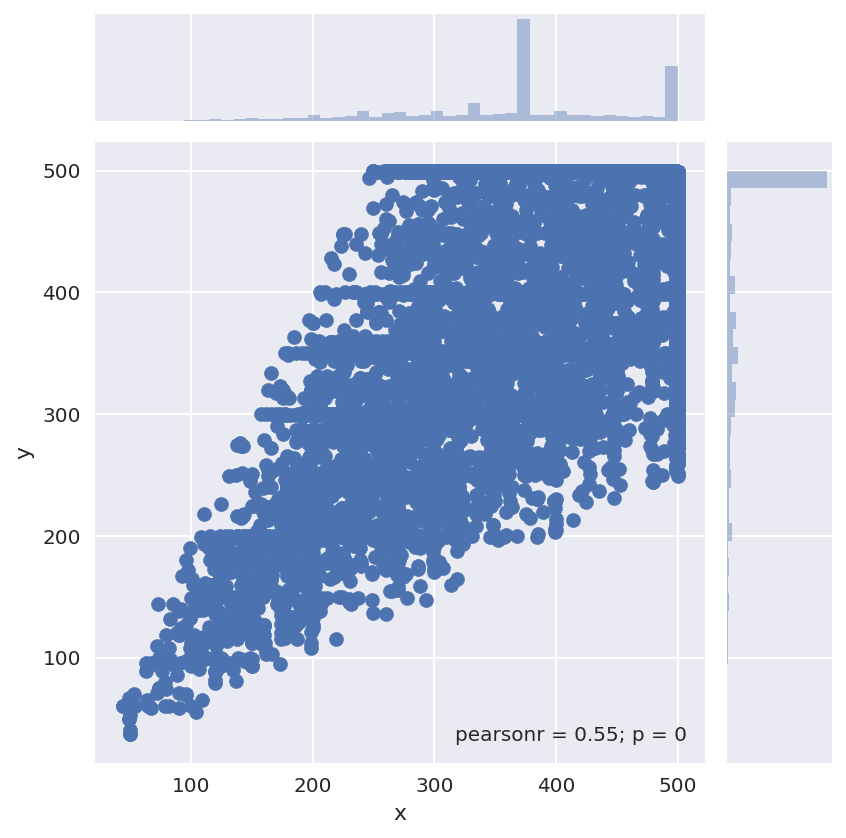

In [33]:
sns.set(color_codes=True)
sns.jointplot(x="x", y="y", data=df_test);
plt.figure(figsize=(12, 6))

# 异常图分析

(25000,)


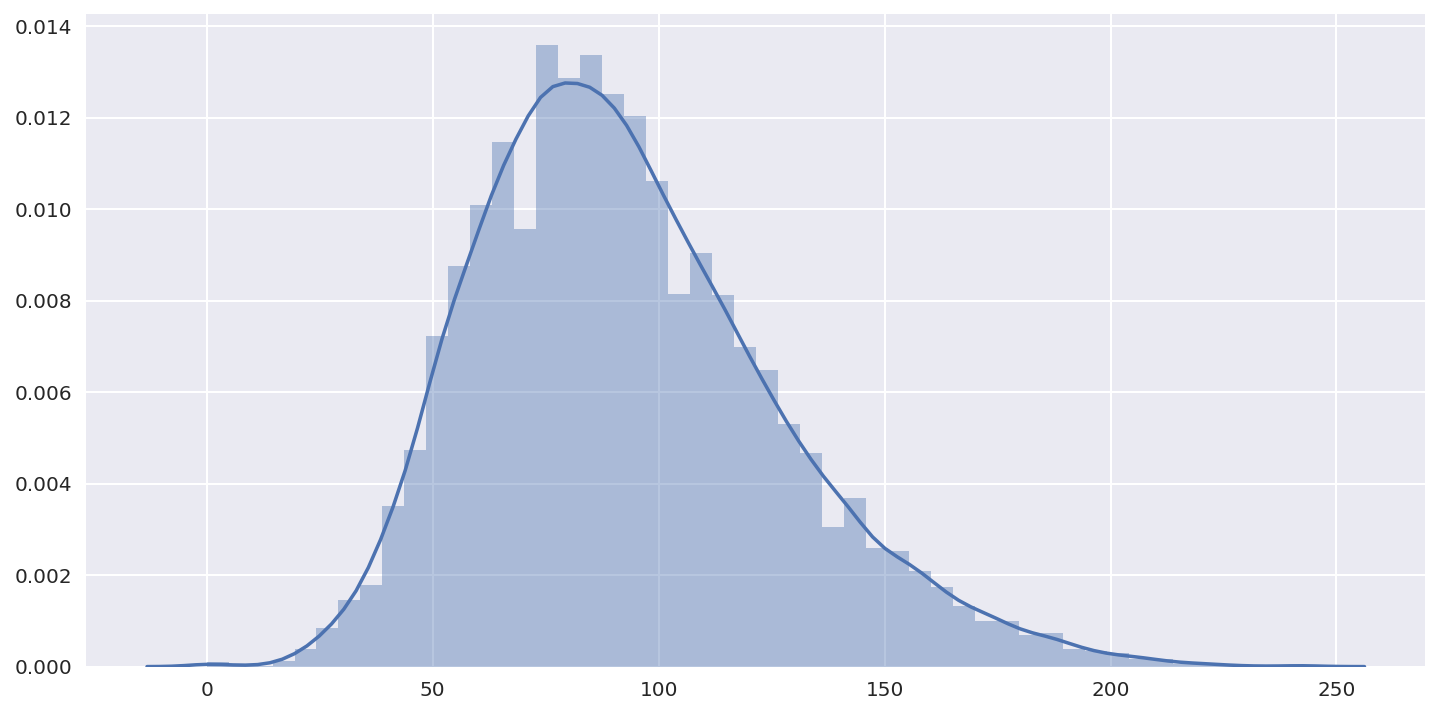

In [74]:
from scipy.stats import iqr

plt.figure(figsize=(12, 6))
arr_x = X.reshape((25000, 299*299*3))
arr_iq = iqr(arr_x, axis=1)
sns.set(color_codes=True)
sns.distplot(arr_iq);
print(arr_iq.shape)

In [132]:
x_ids =  np.where(arr_iq < 10)[0]
x_ids

array([ 2939,  4522,  7564,  8068,  8456,  8470, 10029, 11928, 15897,
       16253, 16494, 16627, 16718, 16888, 18038, 21236])

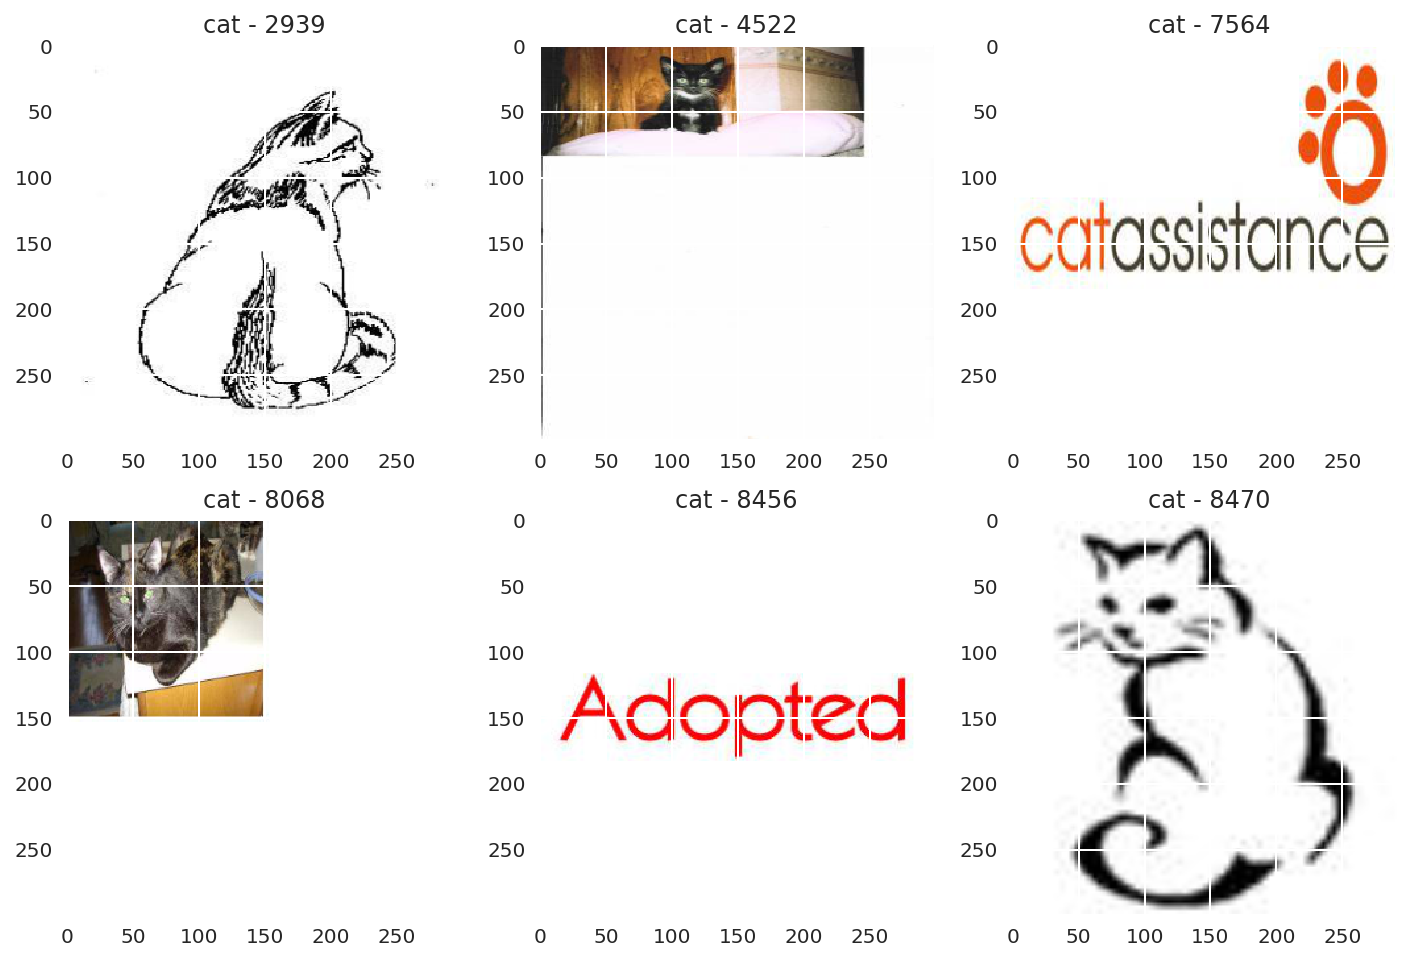

In [133]:
plt.figure(figsize=(12, 8))
for i in range(6):
    pic_id = int(x_ids[i])
    plt.subplot(2, 3, i+1)
    plt.imshow(X[pic_id][:,:,::-1])
    if y[pic_id] == 0:
        plt.title('cat - ' + str(pic_id))
    else:
        plt.title('dog - ' + str(pic_id - 12500))

In [118]:
x_ids =  np.where(arr_iq > 230)[0]
x_ids

array([ 7032, 11301, 11565, 15377, 22901, 23297])

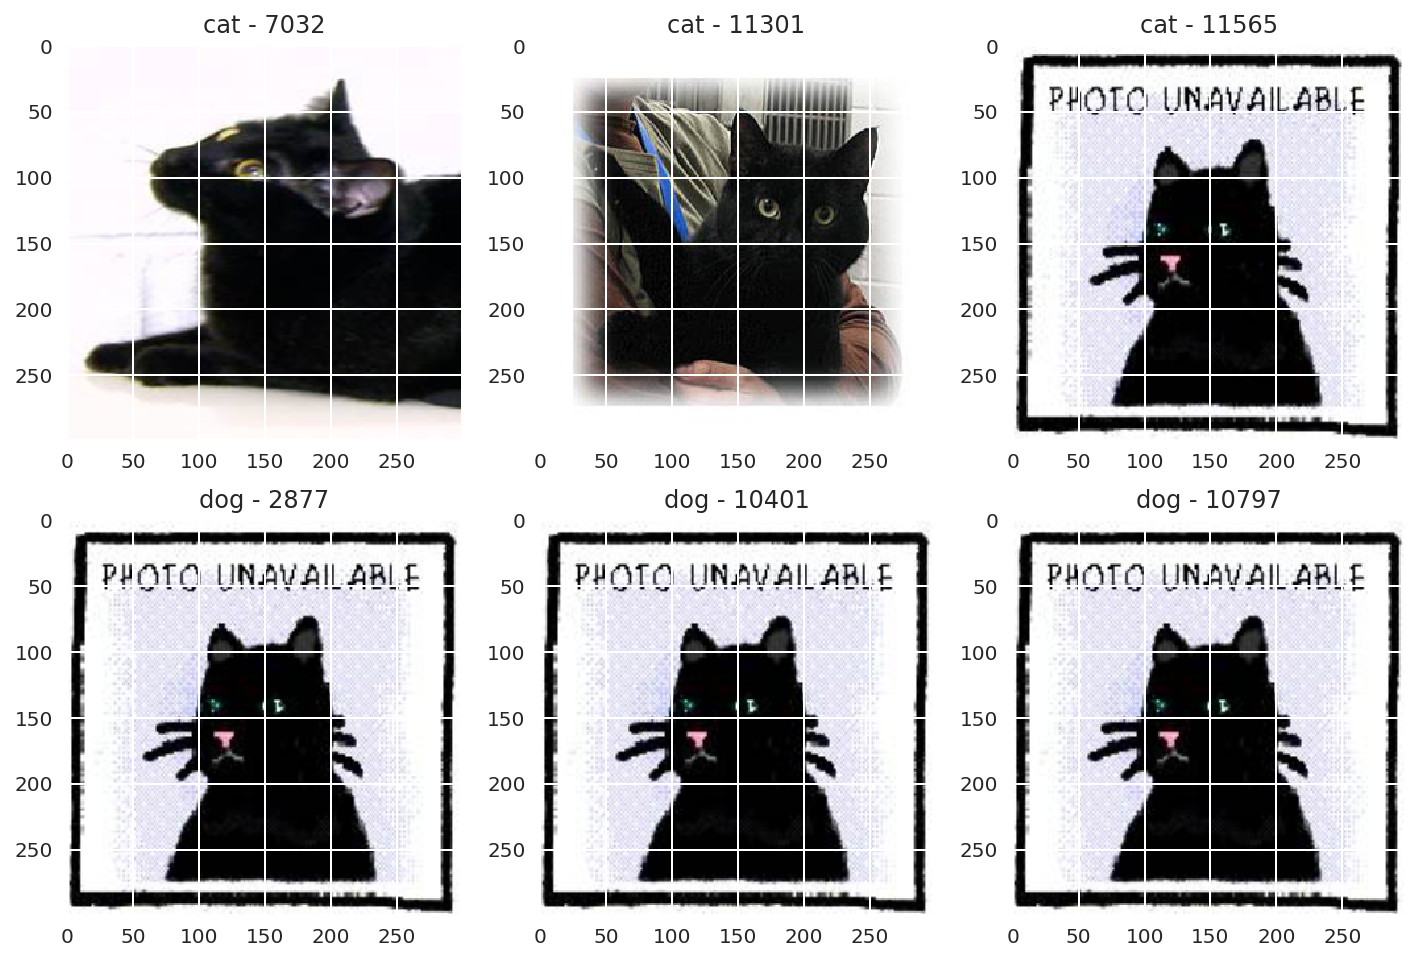

In [127]:
plt.figure(figsize=(12, 8))
for i in range(6):
    pic_id = int(x_ids[i])
    plt.subplot(2, 3, i+1)
    plt.imshow(X[pic_id][:,:,::-1])
    if y[pic_id] == 0:
        plt.title('cat - ' + str(pic_id))
    else:
        plt.title('dog - ' + str(pic_id - 12500))

# 导出特征

In [4]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
# from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [5]:
# For ResNet
def preprocess_input(x):
    return x - [103.939, 116.779, 123.68]

In [6]:
def get_features(MODEL, data=X, prefix=''):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    
    with h5py.File("./cache/{0}fea_{1}.h5".format(prefix, MODEL.__name__)) as h:
        h.create_dataset("features", data=features)
        
    return features

In [7]:
# inception_features = get_features(InceptionV3, X, 'train_')
xception_features = get_features(Xception, X, 'train_')
inceRes_features = get_features(InceptionResNetV2, X, 'train_')
resnet_features = get_features(ResNet50, X, 'train_')

# features = np.concatenate([inception_features, xception_features, inceRes_features], axis=-1)
features = resnet_features
features.shape

25000/25000 [==============================] - 84s    


(25000, 2048)

In [5]:
def get_data(filename):
    with h5py.File(filename, 'r') as data:
        return np.array(data['features'])

In [6]:
inception_features = get_data('./cache/train_fea_InceptionV3.h5')
xception_features = get_data('./cache/train_fea_Xception.h5')
inceRes_features = get_data('./cache/train_fea_InceptionResNetV2.h5')
# resnet_features = get_data('./cache/train_fea_ResNet50.h5')

features = np.concatenate([inception_features, xception_features, inceRes_features], axis=-1)
features.shape

# 训练模型 / InceptionV3 / 0.05484

In [39]:
features = inception_features
X, y_train = shuffle(features, y)
features.shape

(25000, 2048)

In [40]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
adam = Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X, y_train, batch_size=256, epochs=15, 
              shuffle=True, 
              validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/15
22500/22500 [==============================] - 0s - loss: 0.2122 - acc: 0.9257 - val_loss: 0.0627 - val_acc: 0.9872
Epoch 2/15
22500/22500 [==============================] - 0s - loss: 0.0598 - acc: 0.9860 - val_loss: 0.0412 - val_acc: 0.9912
Epoch 3/15
22500/22500 [==============================] - 0s - loss: 0.0468 - acc: 0.9878 - val_loss: 0.0330 - val_acc: 0.9936
Epoch 4/15
22500/22500 [==============================] - 0s - loss: 0.0380 - acc: 0.9899 - val_loss: 0.0296 - val_acc: 0.9932
Epoch 5/15
22500/22500 [==============================] - 0s - loss: 0.0355 - acc: 0.9900 - val_loss: 0.0269 - val_acc: 0.9936
Epoch 6/15
22500/22500 [==============================] - 0s - loss: 0.0319 - acc: 0.9902 - val_loss: 0.0255 - val_acc: 0.9936
Epoch 7/15
22500/22500 [==============================] - 0s - loss: 0.0308 - acc: 0.9907 - val_loss: 0.0245 - val_acc: 0.9936
Epoch 8/15
22500/22500 [==============================] - 0s -

# 可视化训练过程 / InceptionV3

Text(0.5,0,'epoch')

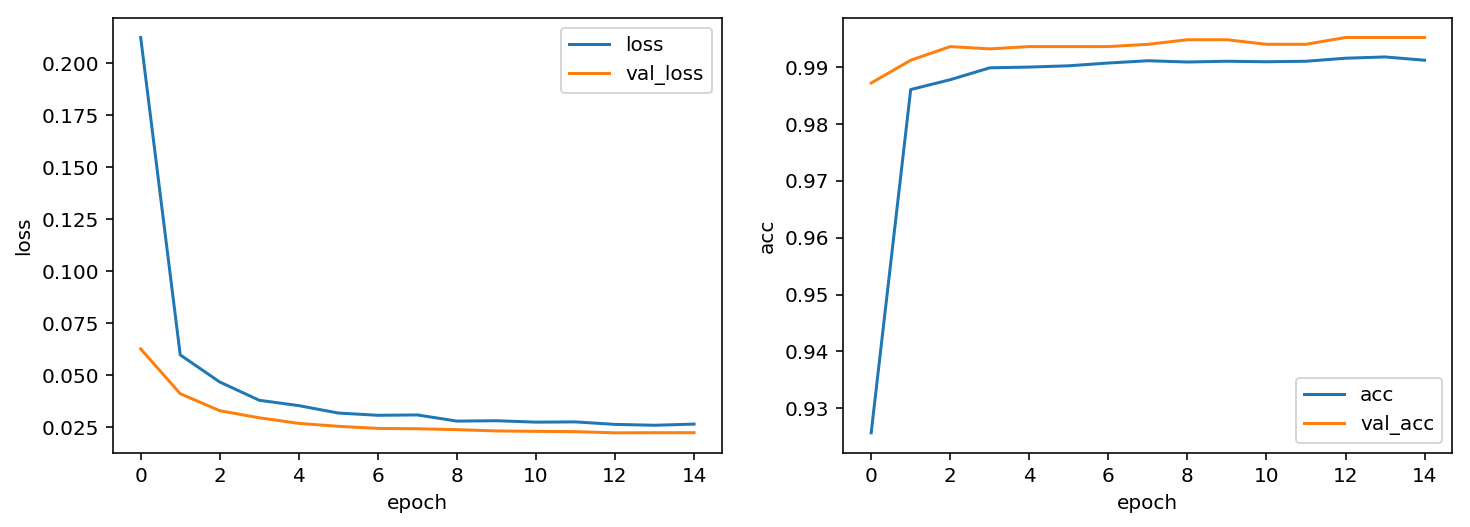

In [41]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# 训练模型 / Xception / 0.05128

In [42]:
features = xception_features
X, y_train = shuffle(features, y)
features.shape

(25000, 2048)

In [43]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
adam = Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X, y_train, batch_size=256, epochs=15, 
              shuffle=True, 
              validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/15
22500/22500 [==============================] - 0s - loss: 0.2073 - acc: 0.9525 - val_loss: 0.0674 - val_acc: 0.9900
Epoch 2/15
22500/22500 [==============================] - 0s - loss: 0.0594 - acc: 0.9886 - val_loss: 0.0412 - val_acc: 0.9920
Epoch 3/15
22500/22500 [==============================] - 0s - loss: 0.0433 - acc: 0.9896 - val_loss: 0.0325 - val_acc: 0.9936
Epoch 4/15
22500/22500 [==============================] - 0s - loss: 0.0362 - acc: 0.9905 - val_loss: 0.0276 - val_acc: 0.9940
Epoch 5/15
22500/22500 [==============================] - 0s - loss: 0.0323 - acc: 0.9904 - val_loss: 0.0253 - val_acc: 0.9948
Epoch 6/15
22500/22500 [==============================] - 0s - loss: 0.0292 - acc: 0.9916 - val_loss: 0.0232 - val_acc: 0.9944
Epoch 7/15
22500/22500 [==============================] - 0s - loss: 0.0274 - acc: 0.9920 - val_loss: 0.0224 - val_acc: 0.9944
Epoch 8/15
22500/22500 [==============================] - 0s -

# 可视化训练过程 / Xception

Text(0.5,0,'epoch')

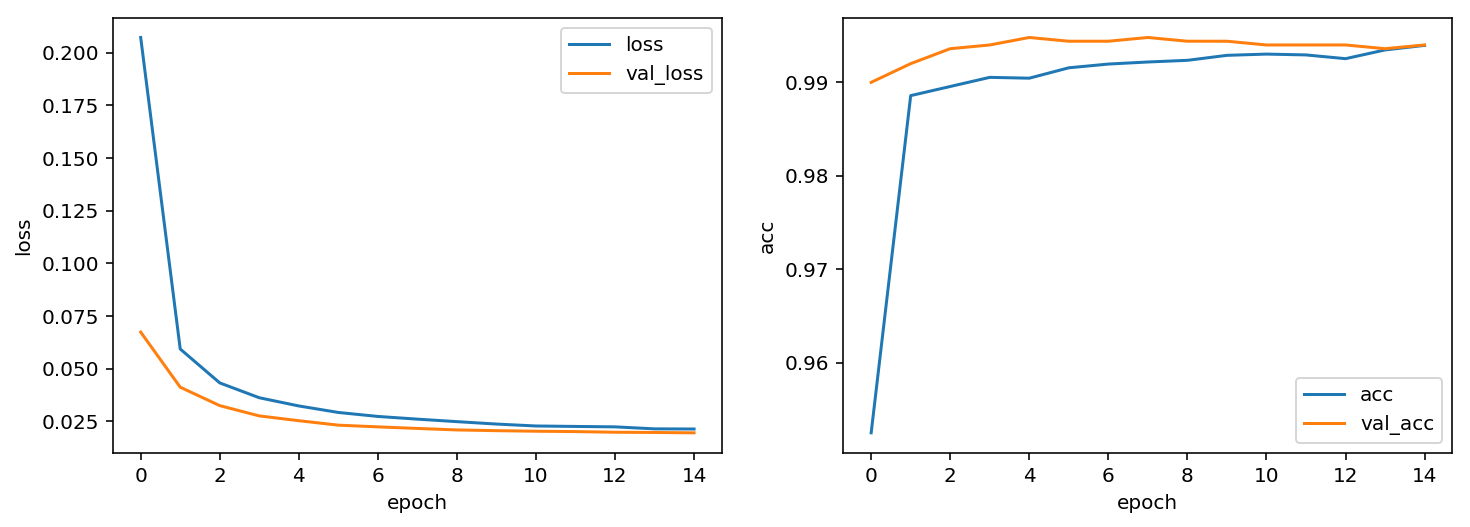

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# 训练模型 / InceptionResNetV2 / 0.05096

In [45]:
features = inceRes_features
X, y_train = shuffle(features, y)
features.shape

(25000, 1536)

In [46]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
adam = Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X, y_train, batch_size=256, epochs=15, 
              shuffle=True, 
              validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/15
22500/22500 [==============================] - 0s - loss: 0.1799 - acc: 0.9456 - val_loss: 0.0594 - val_acc: 0.9880
Epoch 2/15
22500/22500 [==============================] - 0s - loss: 0.0503 - acc: 0.9900 - val_loss: 0.0426 - val_acc: 0.9908
Epoch 3/15
22500/22500 [==============================] - 0s - loss: 0.0376 - acc: 0.9908 - val_loss: 0.0362 - val_acc: 0.9924
Epoch 4/15
22500/22500 [==============================] - 0s - loss: 0.0334 - acc: 0.9923 - val_loss: 0.0333 - val_acc: 0.9924
Epoch 5/15
22500/22500 [==============================] - 0s - loss: 0.0281 - acc: 0.9931 - val_loss: 0.0314 - val_acc: 0.9920
Epoch 6/15
22500/22500 [==============================] - 0s - loss: 0.0270 - acc: 0.9926 - val_loss: 0.0312 - val_acc: 0.9924
Epoch 7/15
22500/22500 [==============================] - 0s - loss: 0.0256 - acc: 0.9932 - val_loss: 0.0300 - val_acc: 0.9928
Epoch 8/15
22500/22500 [==============================] - 0s -

# 可视化训练过程 / InceptionResNetV2

Text(0.5,0,'epoch')

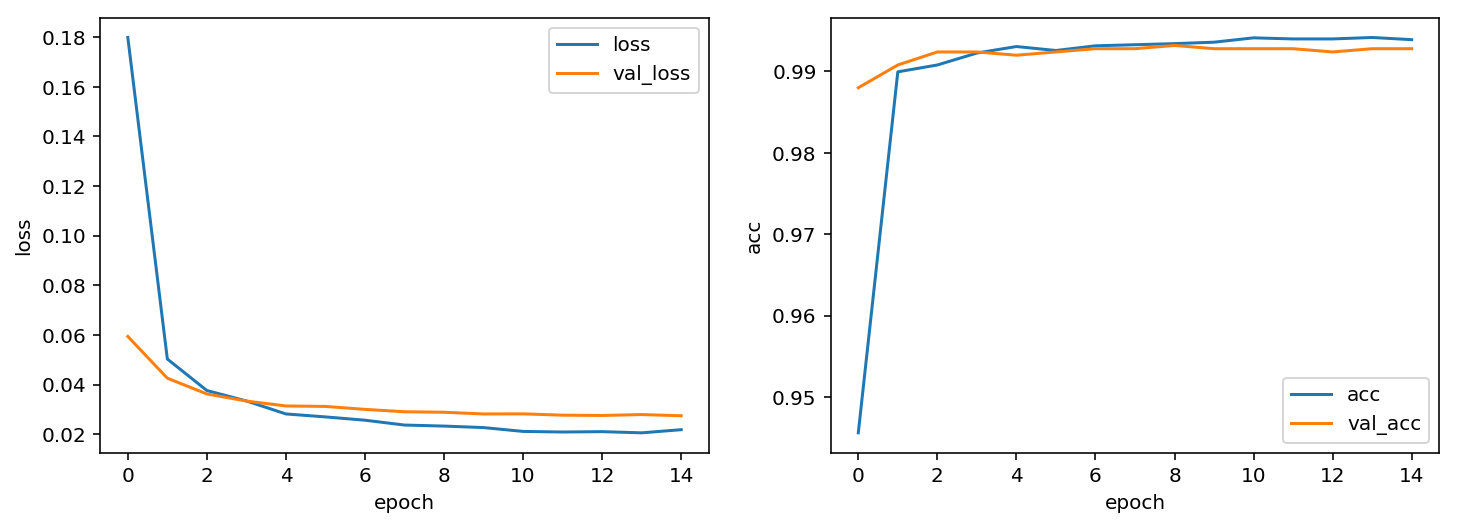

In [47]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# 训练模型 / ResNet50 / 0.06402

In [8]:
features = resnet_features
X, y_train = shuffle(features, y)
features.shape

(25000, 2048)

In [9]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
adam = Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X, y_train, batch_size=256, epochs=15, 
              shuffle=True, 
              validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/15
22500/22500 [==============================] - 0s - loss: 0.1824 - acc: 0.9243 - val_loss: 0.0533 - val_acc: 0.9828
Epoch 2/15
22500/22500 [==============================] - 0s - loss: 0.0601 - acc: 0.9795 - val_loss: 0.0451 - val_acc: 0.9848
Epoch 3/15
22500/22500 [==============================] - 0s - loss: 0.0482 - acc: 0.9834 - val_loss: 0.0381 - val_acc: 0.9856
Epoch 4/15
22500/22500 [==============================] - 0s - loss: 0.0418 - acc: 0.9855 - val_loss: 0.0361 - val_acc: 0.9864
Epoch 5/15
22500/22500 [==============================] - 0s - loss: 0.0402 - acc: 0.9851 - val_loss: 0.0342 - val_acc: 0.9876
Epoch 6/15
22500/22500 [==============================] - 0s - loss: 0.0370 - acc: 0.9864 - val_loss: 0.0338 - val_acc: 0.9872
Epoch 7/15
22500/22500 [==============================] - 0s - loss: 0.0357 - acc: 0.9872 - val_loss: 0.0332 - val_acc: 0.9860
Epoch 8/15
22500/22500 [==============================] - 0s -

# 可视化训练过程 / ResNet50

Text(0.5,0,'epoch')

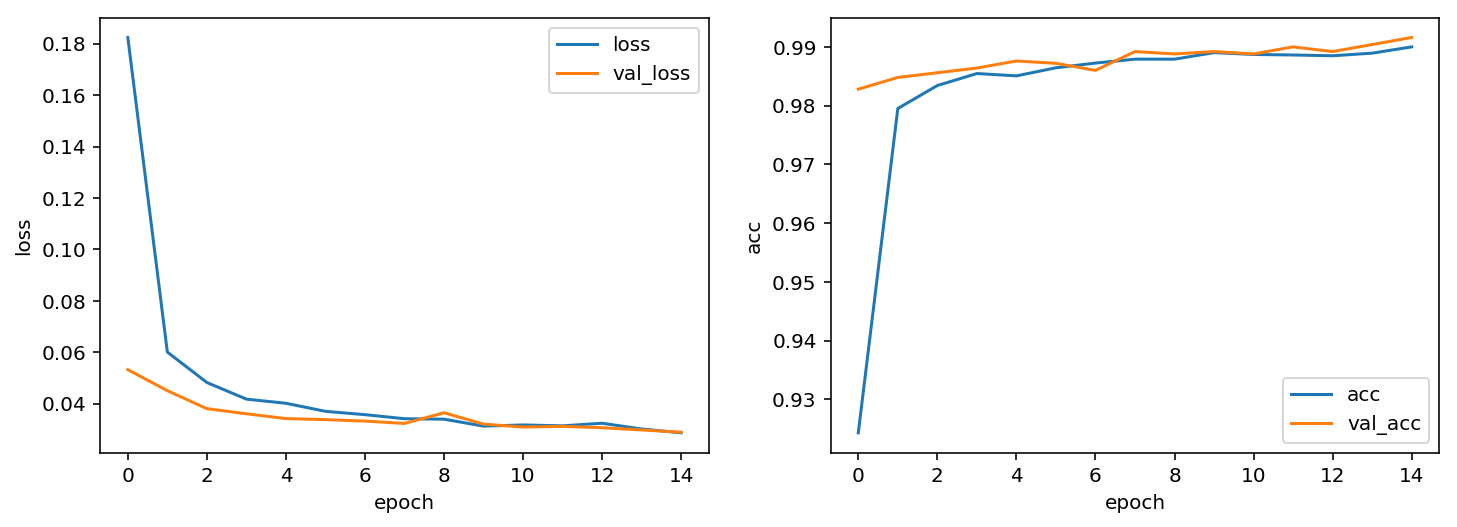

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# InceptionV3 / Xception / InceptionResNetV2 - 0.05438

In [59]:
features =  np.concatenate([inception_features, xception_features, inceRes_features], axis=-1)
X, y_train = shuffle(features, y)
features.shape

(25000, 5632)

In [63]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
adam = Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X, y_train, batch_size=256, epochs=12, 
              shuffle=True, 
              validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/12
22500/22500 [==============================] - 0s - loss: 0.0791 - acc: 0.9745 - val_loss: 0.0257 - val_acc: 0.9936
Epoch 2/12
22500/22500 [==============================] - 0s - loss: 0.0227 - acc: 0.9937 - val_loss: 0.0206 - val_acc: 0.9944
Epoch 3/12
22500/22500 [==============================] - 0s - loss: 0.0184 - acc: 0.9948 - val_loss: 0.0189 - val_acc: 0.9948
Epoch 4/12
22500/22500 [==============================] - 0s - loss: 0.0163 - acc: 0.9952 - val_loss: 0.0176 - val_acc: 0.9948
Epoch 5/12
22500/22500 [==============================] - 0s - loss: 0.0148 - acc: 0.9957 - val_loss: 0.0168 - val_acc: 0.9952
Epoch 6/12
22500/22500 [==============================] - 0s - loss: 0.0149 - acc: 0.9952 - val_loss: 0.0180 - val_acc: 0.9944
Epoch 7/12
22500/22500 [==============================] - 0s - loss: 0.0128 - acc: 0.9962 - val_loss: 0.0158 - val_acc: 0.9960
Epoch 8/12
22500/22500 [==============================] - 0s -

Text(0.5,0,'epoch')

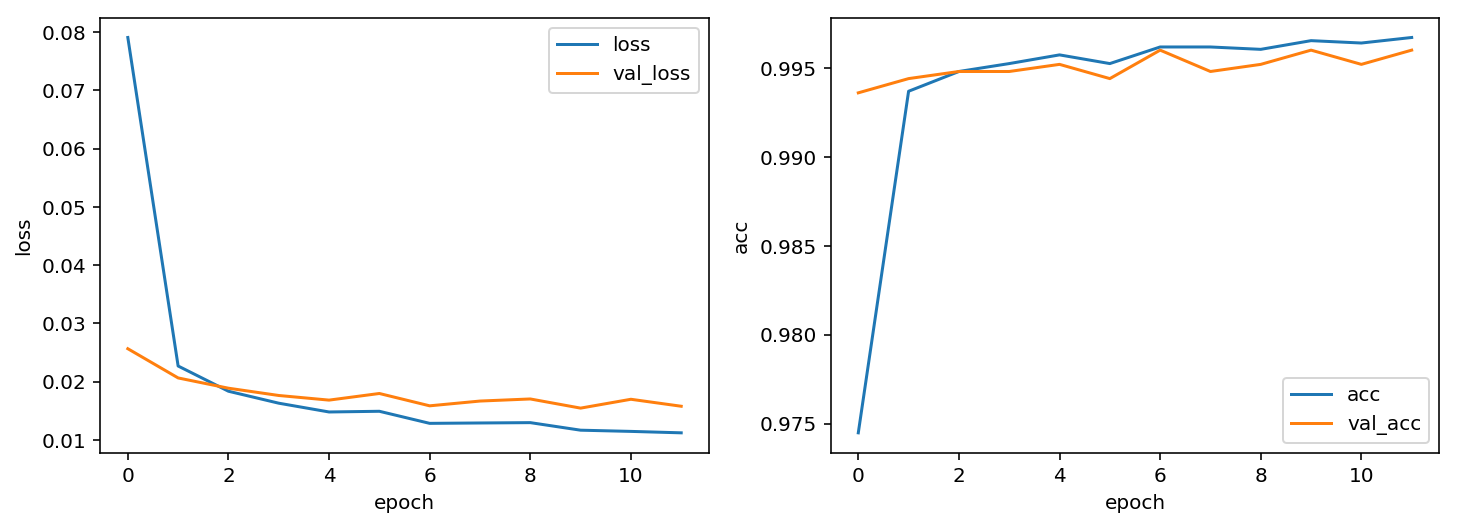

In [64]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# Xception / InceptionV3 - 0.05389

In [65]:
features =  np.concatenate([inception_features, xception_features], axis=-1)
X, y_train = shuffle(features, y)
features.shape

(25000, 4096)

In [66]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
adam = Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X, y_train, batch_size=256, epochs=12, 
              shuffle=True, 
              validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/12
22500/22500 [==============================] - 0s - loss: 0.1001 - acc: 0.9737 - val_loss: 0.0378 - val_acc: 0.9892
Epoch 2/12
22500/22500 [==============================] - 0s - loss: 0.0304 - acc: 0.9916 - val_loss: 0.0323 - val_acc: 0.9888
Epoch 3/12
22500/22500 [==============================] - 0s - loss: 0.0234 - acc: 0.9932 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 4/12
22500/22500 [==============================] - 0s - loss: 0.0206 - acc: 0.9940 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 5/12
22500/22500 [==============================] - 0s - loss: 0.0183 - acc: 0.9943 - val_loss: 0.0280 - val_acc: 0.9908
Epoch 6/12
22500/22500 [==============================] - 0s - loss: 0.0178 - acc: 0.9941 - val_loss: 0.0283 - val_acc: 0.9924
Epoch 7/12
22500/22500 [==============================] - 0s - loss: 0.0169 - acc: 0.9943 - val_loss: 0.0284 - val_acc: 0.9928
Epoch 8/12
22500/22500 [==============================] - 0s -

Text(0.5,0,'epoch')

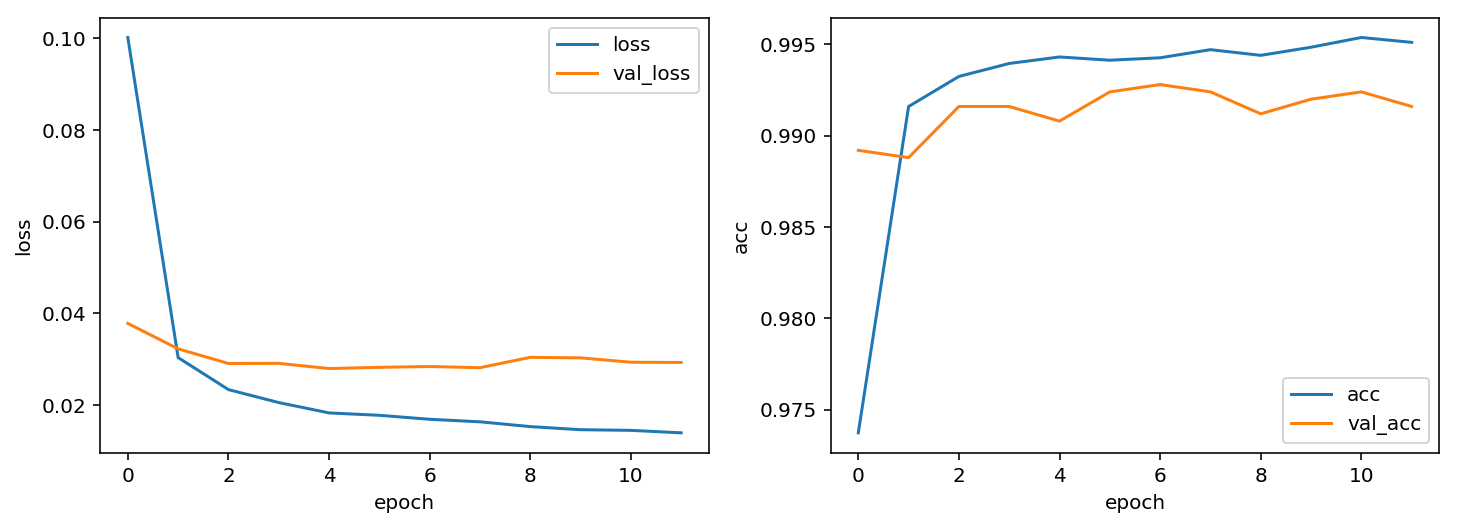

In [67]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# Xception / InceptionResNetV2 - 0.04905

In [68]:
features =  np.concatenate([xception_features, inceRes_features], axis=-1)
X, y_train = shuffle(features, y)
features.shape

(25000, 3584)

In [69]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
adam = Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X, y_train, batch_size=256, epochs=12, 
              shuffle=True, 
              validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/12
22500/22500 [==============================] - 0s - loss: 0.1082 - acc: 0.9733 - val_loss: 0.0285 - val_acc: 0.9944
Epoch 2/12
22500/22500 [==============================] - 0s - loss: 0.0298 - acc: 0.9931 - val_loss: 0.0202 - val_acc: 0.9948
Epoch 3/12
22500/22500 [==============================] - 0s - loss: 0.0236 - acc: 0.9938 - val_loss: 0.0175 - val_acc: 0.9952
Epoch 4/12
22500/22500 [==============================] - 0s - loss: 0.0210 - acc: 0.9943 - val_loss: 0.0152 - val_acc: 0.9948
Epoch 5/12
22500/22500 [==============================] - 0s - loss: 0.0190 - acc: 0.9946 - val_loss: 0.0143 - val_acc: 0.9956
Epoch 6/12
22500/22500 [==============================] - 0s - loss: 0.0175 - acc: 0.9948 - val_loss: 0.0143 - val_acc: 0.9952
Epoch 7/12
22500/22500 [==============================] - 0s - loss: 0.0175 - acc: 0.9950 - val_loss: 0.0150 - val_acc: 0.9952
Epoch 8/12
22500/22500 [==============================] - 0s -

Text(0.5,0,'epoch')

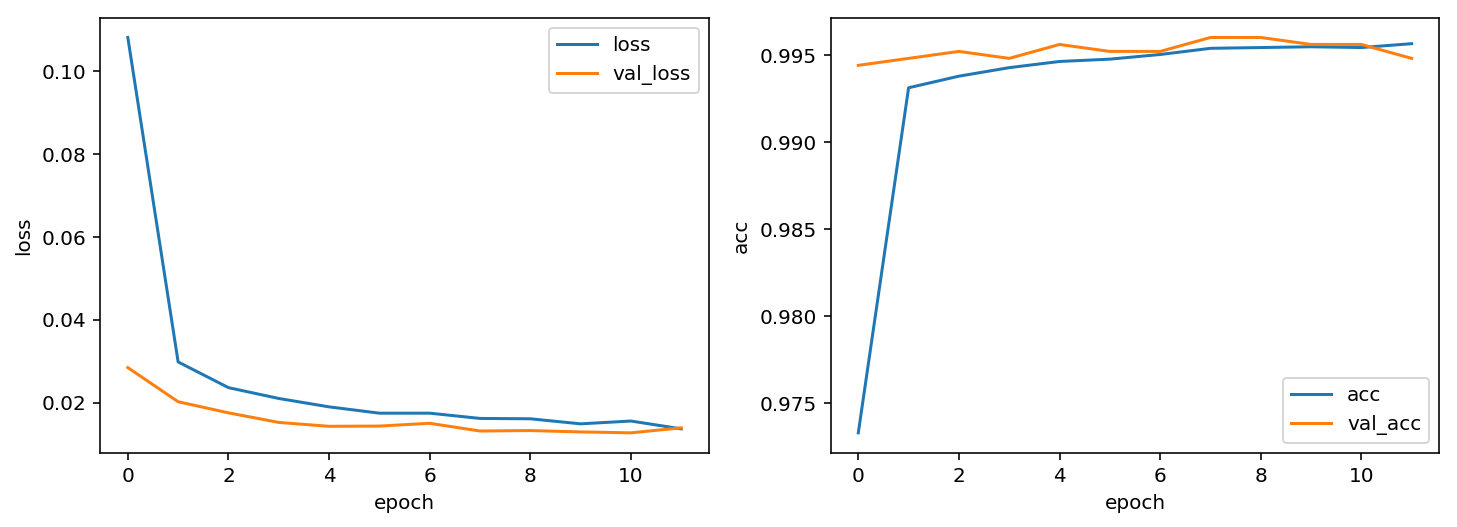

In [70]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# InceptionV3 / InceptionResNetV2 - 0.04791

In [71]:
features =  np.concatenate([inception_features, inceRes_features], axis=-1)
X, y_train = shuffle(features, y)
features.shape

(25000, 3584)

In [72]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
adam = Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X, y_train, batch_size=256, epochs=12, 
              shuffle=True, 
              validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/12
22500/22500 [==============================] - 0s - loss: 0.1084 - acc: 0.9663 - val_loss: 0.0263 - val_acc: 0.9940
Epoch 2/12
22500/22500 [==============================] - 0s - loss: 0.0306 - acc: 0.9922 - val_loss: 0.0186 - val_acc: 0.9968
Epoch 3/12
22500/22500 [==============================] - 0s - loss: 0.0240 - acc: 0.9934 - val_loss: 0.0151 - val_acc: 0.9976
Epoch 4/12
22500/22500 [==============================] - 0s - loss: 0.0212 - acc: 0.9939 - val_loss: 0.0141 - val_acc: 0.9976
Epoch 5/12
22500/22500 [==============================] - 0s - loss: 0.0204 - acc: 0.9941 - val_loss: 0.0148 - val_acc: 0.9956
Epoch 6/12
22500/22500 [==============================] - 0s - loss: 0.0190 - acc: 0.9943 - val_loss: 0.0153 - val_acc: 0.9948
Epoch 7/12
22500/22500 [==============================] - 0s - loss: 0.0182 - acc: 0.9944 - val_loss: 0.0130 - val_acc: 0.9968
Epoch 8/12
22500/22500 [==============================] - 0s -

Text(0.5,0,'epoch')

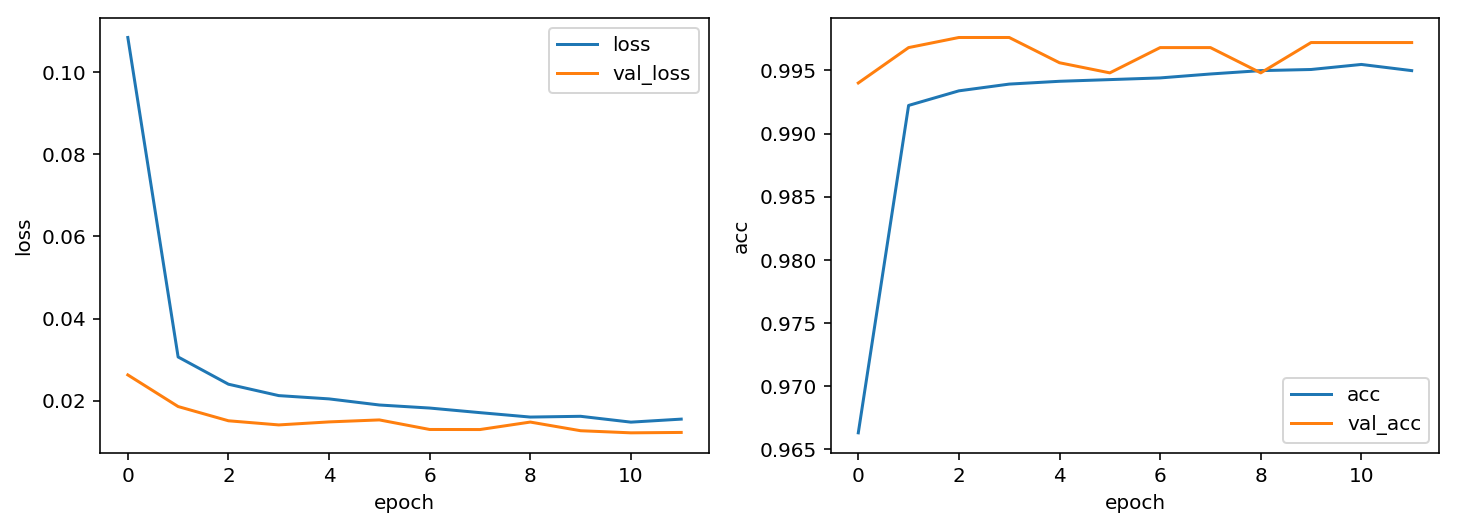

In [73]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# 载入测试集

In [11]:
df_sub = pd.read_csv('./sample_submission.csv')

In [12]:
n_test = 12500
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('./test/%s.jpg' % (i+1)), (width, width))

100%|██████████| 12500/12500 [00:19<00:00, 627.68it/s]


# 导出测试集特征

In [13]:
# inception_features = get_features(InceptionV3, X_test, 'test_')
# xception_features = get_features(Xception, X_test, 'test_')
# inceRes_features = get_features(InceptionResNetV2, X_test, 'test_')
resnet_features = get_features(ResNet50, X_test, 'test_')

# features_test = np.concatenate([inception_features, xception_features, inceRes_features], axis=-1)
features_test = resnet_features
features_test.shape

12500/12500 [==============================] - 41s    


(12500, 2048)

In [15]:
inception_features = get_data('./cache/test_fea_InceptionV3.h5')
xception_features = get_data('./cache/test_fea_Xception.h5')
inceRes_features = get_data('./cache/test_fea_InceptionResNetV2.h5')
# resnet_features = get_data('./cache/test_fea_ResNet50.h5')

features_test = np.concatenate([inception_features, xception_features, inceRes_features], axis=-1)
features_test.shape

(12500, 2048)

# 预测测试集并优化输出结果

In [14]:
df_sub['label'] = model.predict(features_test, batch_size=128)

In [17]:
labels = []

for index, row in df_sub.iterrows():
    if row['label'] > 0.995:
        labels.append(0.995)
    elif row['label'] < 0.005:
        labels.append(0.005)
    else:
        labels.append(row['label'])

df_sub['label'] = labels

In [15]:
df_sub.head(10)

,id,label
0,1,0.999925
1,2,0.999992
2,3,0.999982
3,4,0.999495
4,5,0.000032
5,6,0.000081
6,7,0.000026
7,8,0.000006
8,9,0.000030
9,10,0.000425


In [20]:
df_sub.to_csv('result_res.csv', index=None)